Elaborato di Progetto - Data Intensive 2020, Christian D'Errico

Setup delle librerie e definizioni di funzioni utili:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
import os
from bs4 import BeautifulSoup
import random
import re
import colorama
import time
import timeit
from colorama import Back, Fore, Style
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import f1_score
from scipy.stats import norm
from sklearn.metrics import accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt');
nltk.download("vader_lexicon");
nltk.download("averaged_perceptron_tagger");
nltk.download("stopwords");

[nltk_data] Downloading package punkt to C:\Users\Famiglia
[nltk_data]     D'Errico\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Famiglia
[nltk_data]     D'Errico\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Famiglia
[nltk_data]     D'Errico\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\Famiglia
[nltk_data]     D'Errico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [4]:
def model_conf_interval(model, X, y, level=0.95):
    if type(model) == float:
        a = model
    else:
        a = model.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

In [5]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

In [6]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    if type(m2) == float: 
        a2 = m2
    else:
        a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

Prima di procedere con l'analisi, ringrazio gli autori per aver reso disponibile il dataset e cito l'articolo al seguente URL che lo presenta: https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf, Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)

References

Potts, Christopher. 2011. On the negativity of negation. In Nan Li and
David Lutz, eds., Proceedings of Semantics and Linguistic Theory 20,
636-659.

Contact

For questions/comments/corrections please contact Andrew Maas
amaas@cs.stanford.edu

In [7]:
t = time.time() #necessario a misurare la durata di esecuzione del notebook

# Sentiment Analsys su recensioni di film tratte da IMDB

L'analisi del sentiment o sentiment analysis (nota anche come opinion mining) è un campo dell'elaborazione del linguaggio naturale che si occupa di costruire sistemi per l'identificazione ed estrazione di opinioni dal testo.

In questo caso, si è voluto sottoporre ad un tale studio un sottoinsieme di 10.000 recensioni tratte dal sito https://www.imdb.com/, per scoprire quale fosse l'orientamento dei giudizi prodotti dagl'utenti sulle produzioni cinematografiche.

# Esportazione dei dati

I dati vengono prima elaborati e caricati in un DataFrame Pandas:

- il contenuto di ogni file .txt è il testo della recensione
- il nome di ogni file è composto dalle seguenti parti: "`id del film in questione`_`punteggio attribuito dall'utente`"
  

In [8]:
files = []  #lista che contiene i vari file .txt con il loro percorso 
for dirpath, dirnames, filenames in os.walk("C:\\Users\\Famiglia D\'Errico\\Desktop\\Tesi2020\\files\\regioni\\aclImdb - Copia"):
    for file in filenames:
        files.append(dirpath + '\\' + file)

Per ogni file è stato letto il contenuto e dal nome sono stati prelevati i campi relativi ad id e valutazione:

In [9]:
reviews = []
for file in files:
    with open(file, "r", encoding="utf8") as f:
        reviews.append((f.readlines())[0])

In [10]:
film_dict = {"film_id": pd.Series([int(f.split("\\")[-1].split("_")[0]) for f in files]), 
        "rating": pd.Series([int(f.split("\\")[-1].split("_")[1].split(".")[0]) for f in files]), 
          "review": reviews} 

In [11]:
film_reviews_full = pd.DataFrame(film_dict)
film_reviews_full = film_reviews_full.sort_values(by="film_id").reset_index().drop(columns="index")

Ecco il dataset prodotto da questa prima fase di elaborazione:
- sono presenti 50.000 recensioni
- Le colonne sono 3:
    - `film_id` contiene gli identificatori numerici associati ai film recensiti
    - `rating` contiene i punteggi che gli utenti hanno attribuito ai film
    - `review` contiene i testi della recensioni redatte dagli utenti

In [12]:
film_reviews_full.head()

,film_id,rating,review
0,0,2,Once again Mr. Costner has dragged out a movie...
1,0,10,I went and saw this movie last night after bei...
2,0,3,Story of a man who has unnatural feelings for ...
3,0,9,Bromwell High is a cartoon comedy. It ran at t...
4,1,10,My boyfriend and I went to watch The Guardian....


In [13]:
film_reviews_full.tail()

,film_id,rating,review
49995,12498,7,I'm torn about this show. While MOST parts of ...
49996,12499,10,I was plagued by nightmares involving Sesame S...
49997,12499,2,I went to the movie as a Sneak Preview in Aust...
49998,12499,7,I always feel strange and guilty saying it (be...
49999,12499,1,This movie was sooo bad. It wasn't even funny ...


In [14]:
film_reviews_full.shape

(50000, 3)

# Rimozione tag HTML

Il testo delle recensioni contiene alcuni tag HTML `<br />`, che contribuiscono a "sporcare" i dati testuali:

In [15]:
substrings = re.split('(<br />)', reviews[1])
substrings.remove('')
print(substrings[0] + f"{Back.LIGHTBLACK_EX}" + f"{Fore.WHITE}" + substrings[1] + substrings[2] + f"{Style.RESET_ALL}" + substrings[3])

This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to se

Pertanto, utilizzando il parser HTML del framework BeautifulSoup per rimuovere i tag con scarso significato semantico:

In [16]:
reviews_filtered = [BeautifulSoup(rev, "html.parser").get_text() for rev in reviews]
film_reviews_full['review'] = reviews_filtered

Ecco il testo "depurato" dei `<br />`:

In [17]:
reviews_filtered[1]

"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...Overall, this is second-rate action trash. There are countless better films to see, and if you really want to see this one,

In [18]:
film_dict = {"film_id": pd.Series([int(f.split("\\")[-1].split("_")[0]) for f in files]), 
        "rating": pd.Series([int(f.split("\\")[-1].split("_")[1].split(".")[0]) for f in files]), 
          "review": reviews_filtered}
film_reviews_full = pd.DataFrame(film_dict)

Aumento il numero di caratteri per migliorare la visualizzazione della colonna `review`:

In [19]:
pd.options.display.max_colwidth = 100
film_reviews_full.sort_values(by='film_id', inplace=True)
film_reviews_full

,film_id,rating,review
0,0,2,Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the ter...
12500,0,10,I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit ...
25000,0,3,Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a t...
37500,0,9,Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school l...
16111,1,10,"My boyfriend and I went to watch The Guardian.At first I didn't want to watch it, but I loved th..."
...,...,...,...
15274,12498,7,"I'm torn about this show. While MOST parts of it I found to be HILARIOUS, other parts of it I fo..."
15275,12499,10,I was plagued by nightmares involving Sesame Street and the Muppet Show during my childhood. I l...
27775,12499,2,I went to the movie as a Sneak Preview in Austria. So didn't have an idea what I am going to see...
40275,12499,7,"I always feel strange and guilty saying it (because I'm a fairly well-educated non-teenager), bu..."


# 1) Analisi esplorativa

Il numero di recensioni per valutazioni è: 

In [20]:
film_reviews_full['rating'].value_counts()

1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: rating, dtype: int64

Il grafico a torta che segue mostra visivamente questi dati:

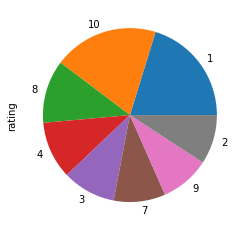

In [21]:
film_reviews_full['rating'].value_counts().plot.pie();

# Binarizzazione

Una recensione è considerata negativa se il valore assegnato risulta minore o uguale a 4, mentre una recensione positiva ha un punteggio superiore o uguale a 7:

In [22]:
film_reviews_full['label'] = np.where(film_reviews_full['rating'] <= 4, "neg", "pos")

In quanto tali, le recensioni sono equamente distribuite in due parti equinumerose:
- 25.000 recensioni positive
- 25.000 recensioni negative

In [23]:
film_reviews_full['label'].value_counts()

pos    25000
neg    25000
Name: label, dtype: int64

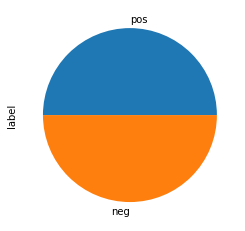

In [24]:
film_reviews_full['label'].value_counts().plot.pie();

**NOTA**: *Per semplificare i calcoli in fase di addestramento e validazione dei modelli ho ridotto il numero di istanze da 50000 a 10000, mantenendo invariata la distribuzione delle classi*

In [25]:
a = film_reviews_full.loc[film_reviews_full['label'] == 'pos'].sample(n=5000, random_state=9)
b = film_reviews_full.loc[film_reviews_full['label'] == 'neg'].sample(n=5000, random_state=9)
film_reviews = a.append(b).sort_values(by='film_id')

In [26]:
film_reviews['rating'].value_counts()

1     2002
10    1970
8     1159
4     1074
3      974
2      950
7      944
9      927
Name: rating, dtype: int64

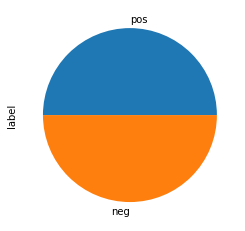

In [27]:
film_reviews['label'].value_counts().plot.pie();

In [28]:
film_reviews['label'].value_counts()

pos    5000
neg    5000
Name: label, dtype: int64

In [29]:
film_reviews.shape

(10000, 4)

La colonna "film_id" contiene un dato non utile al problema, quindi elimino la colonna e uso come identificativo l'indice aggiunto in automatico da Pandas:

In [30]:
if "film_id" in film_reviews:
    film_reviews.drop(columns="film_id", inplace=True)
film_reviews.head()

,rating,review,label
28611,1,Robert DeNiro plays the most unbelievably intelligent illiterate of all time. This movie is so w...,neg
16111,10,"My boyfriend and I went to watch The Guardian.At first I didn't want to watch it, but I loved th...",pos
17222,7,My yardstick for measuring a movie's watch-ability is if I get squirmy. If I start shifting posi...,pos
4722,3,"It seems ever since 1982, about every two or three years we get a movie that claims to be ""The N...",neg
18333,7,How many movies are there that you can think of when you see a movie like this? I can't count th...,pos


L'istogramma che segue mostra la distribuzione dei caratteri delle recensioni: si può notare come la maggioranza delle recensioni realizzate dagl'utenti siano di una lunghezza compresa fra 0 e 2000 caratteri, e che superati la soglia dei 2000 caratteri, il numero di recensioni diminuisca progressivamente fino ad attestarsi ad un massimo di circa 10000 caratteri:

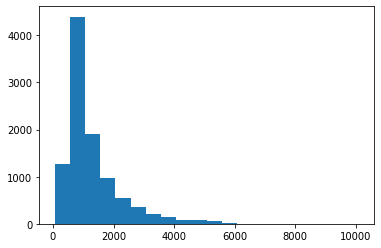

In [31]:
plt.hist(film_reviews['review'].str.len(), bins=20);

Con maggior precisione, il numero medio di caratteri si attesta intorno ai 1300 caratteri, la recensione più breve è di circa 52 caratteri, la più corposa di 10363, mentre la maggioranza delle recensioni non è più lunga di 2000

In [32]:
pd.DataFrame(film_reviews['review'].str.len().sort_values().describe())

,review
count,10000.000000
mean,1270.123600
std,943.140377
min,52.000000
25%,692.000000
50%,950.000000
75%,1536.000000
max,10099.000000


In [33]:
film_reviews['review'].str.len().sort_values().head()

26068     52
36109     80
34436     94
40286    120
47867    131
Name: review, dtype: int64

In [34]:
film_reviews['review'].str.len().sort_values().tail()

41242     6560
34529     6928
34972     7665
28533     8681
43758    10099
Name: review, dtype: int64

Per quanto riguarda invece il numero di parole, segmentate con la funzione split per le stringhe Python, per ciascuna recensione abbiamo le seguenti stime:

In [35]:
reviews = {
    i : [len(film_reviews.loc[i]['review'].split())]
    for i in film_reviews.index.to_list()
}
count_word = pd.DataFrame.from_dict(reviews, orient='index').rename(columns={0:'len'}).sort_values(by='len')

La distribuzione descritta dall'istogramma seguente ci mostra che il numero di parole per la maggioranza delle recensioni si attesta fra le 10 e le 270 circa, soglia che segna l'inzio di un andamento decrescente fino ad un massimo di circa 1800 parole:

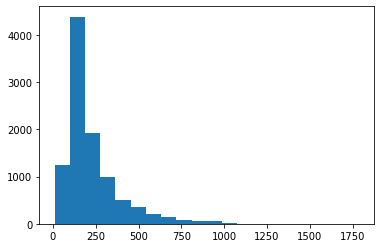

In [36]:
plt.hist(count_word['len'], bins=20);

Il valore medio è di circa 224 parole, la recensione più corta risulta essere di 10 parole, mentre quella più lunga di 1786, il resto dei dati conferma la distribuzione descritta precedentemente:

In [37]:
count_word.describe()

,len
count,10000.000000
mean,224.468100
std,163.320743
min,10.000000
25%,125.000000
50%,170.000000
75%,272.000000
max,1786.000000


In [38]:
count_word['len'].head()

26068    10
36109    14
34436    17
15459    20
47867    23
Name: len, dtype: int64

In [39]:
count_word['len'].tail()

41242    1138
34529    1156
34972    1360
28533    1474
43758    1786
Name: len, dtype: int64

# Vector space model

Per effettuare la Sentiment Analsys è stato definita una Bag of Word, contenente l'insieme delle parole in ogni documento, senza ripetizioni e senza considerare il loro ordine all'interno dei documenti:
- definito un dizionario in comune, ogni recensione viene tradotta in un vettore all'interno dell'iperspazio di classificazione, in cui ad ogni singola parola viene associato un peso in relazione alla sua occorrenza all'interno delle recensioni.
- le dimensioni dello spazio vettoriale sono date dal numero di parole distinte identificate
- l'insieme di documenti diventa dunque rappresentabile come una matrice documenti - termini, che avrà tante righe quanti i documenti analizzati (in questo caso le recensioni) e colonne quante le parole distinte.

Il più semplice esempio di Vector Space Model può essere ottenuto utilizzando un filtro `CountVectorizer`, che converte una collezione di documenti testuali in una matrice di occorrenze dei termini

Quest'ultimo vector space model non tiene conto però conto del peso attribuito ad ogni termine presente all'interno delle recensioni.
Per far questo, è stato utilizzato un filtro `TfidfVectorizer`:
- il filtro calcola il tf, un valore che indica l'importanza locale di un termine in un documento ed è pari al numero di occorrenze (o al suo logaritmo)
- un'altro valore calcolato è l'idf, che indica l'importanza globale di un termine, tanto più alta quanto più il termine è poco comune nell'insieme complessivo dei documenti
- infine, una volta calcolati tutti i pesi, ciascun vettore è normalizzato in modo da avere norma euclidea pari a 1, per appianare differenze di pesi tra documenti più o meno lunghi

In questa prima analisi, ho utilizzato come classificatore il `Perceptron`, un algoritmo di apprendimento molto semplice, concettualmente simile alla discesa gradiente

Per prima cosa preparo gli insiemi di dati che verranno forniti ai modelli: il validation set contiene circa 1/3 del totale delle recensioni, mentre il training set i restanti 2/3.

In [40]:
film_reviews_train, film_reviews_val = train_test_split(film_reviews, test_size=0.3, random_state=42)

In [41]:
model = Pipeline([
    ("vectorizer", None),
    ("classifier", Perceptron())
])

Per la valutazione dei migliori iperparametri ho utilizzato una Grid Search con la seguente griglia:
- i filtri da utilizzare per creare la matrice documenti - termini
- il parametro `ngram_range` per i filtri: con questo parametro viene specificata al filtro la lunghezza dei token; in particolare si specifica se avvalersi esclusivamente di considerare esclusivamente monogrammi (token composti da una singola parola) oppure anche i digrammi (token composto da due parole)
- il parametro `alpha`, per indicare il peso della regolarizzazione per il perceptron
- il parametro `penalty`, per indicare il tipo di regolarizzazione da adottare

In [42]:
grid = [{
    'vectorizer': [CountVectorizer(), 
                   TfidfVectorizer()],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'classifier__alpha': [0.0001, 0.00001, 0.000001],
    'classifier__penalty': ['l1', 'l2', None]
    }]

Il tipo di cross validation utilizzata è una StratifiedKFoldValidation, che a il compito di preservare all'interno dei fold la  distribuzione di partenza delle classi

In [43]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=skf, n_jobs=6)
gs.fit(film_reviews_train["review"], film_reviews_train["label"]);

In [44]:
gs.score(film_reviews_val['review'], film_reviews_val['label'])

0.876

Questi i parametri del modello migliore:

In [45]:
pd.Series(gs.best_params_)

classifier__alpha                                                                                                        1e-06
classifier__penalty                                                                                                         l2
vectorizer                 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n                dtype=<cl...
vectorizer__ngram_range                                                                                                 (1, 2)
dtype: object

E questa la classfica dei migliori modelli:

In [46]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__penalty,param_vectorizer,param_vectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
31,4.425573,0.084635,1.486683,0.451600,1e-06,l2,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<cl...","(1, 2)","{'classifier__alpha': 1e-06, 'classifier__penalty': 'l2', 'vectorizer': TfidfVectorizer(analyzer...",0.856470,0.869696,0.864552,0.863571,0.005444,1
35,4.078279,0.361946,1.323163,0.421963,1e-06,None,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<cl...","(1, 2)","{'classifier__alpha': 1e-06, 'classifier__penalty': None, 'vectorizer': TfidfVectorizer(analyzer...",0.856898,0.868838,0.860266,0.862000,0.005027,2
11,4.427918,0.128942,1.301943,0.099332,0.0001,None,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<cl...","(1, 2)","{'classifier__alpha': 0.0001, 'classifier__penalty': None, 'vectorizer': TfidfVectorizer(analyze...",0.856898,0.868838,0.860266,0.862000,0.005027,2
23,4.726039,0.224878,1.180275,0.040809,1e-05,None,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<cl...","(1, 2)","{'classifier__alpha': 1e-05, 'classifier__penalty': None, 'vectorizer': TfidfVectorizer(analyzer...",0.856898,0.868838,0.860266,0.862000,0.005027,2
19,4.457039,0.130324,1.241798,0.056772,1e-05,l2,"TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<cl...","(1, 2)","{'classifier__alpha': 1e-05, 'classifier__penalty': 'l2', 'vectorizer': TfidfVectorizer(analyzer...",0.856470,0.867124,0.859837,0.861143,0.004447,5


# Confronto con modello casuale

Il miglior modello restituito dalla Grid Search viene confrontato con un modello che effettua casualmente la sentiment analsys sulle recensioni

In [47]:
def score_random_predictions(X, y):
    pred = []
    len_prediction = len(X)
    for i in range(len_prediction):
        pred.append(random.sample(['pos', 'neg'], 1)[0])
    count = 0
    for i in range(len(y)):
        if pred[i] == y.values[i]:
            count += 1
    return count / len(y)

L'accuratezza del modello casuale si attesta comprensibilmente sul 50%, essendo questo un problema di classificazione binario con una probabilità di successo di 1/2

In [48]:
scoring = score_random_predictions(film_reviews_val['review'], film_reviews_val['label'])
scoring

0.491

Questo l'intervallo di confidenza 95% del modello di predizione casuale:

In [49]:
model_conf_interval(scoring, film_reviews_val['review'], film_reviews_val['label'])

(0.47313390557488116, 0.5088891137021746)

L'intervallo di confidenza al 99% della differenza dei due modelli dimostra la bontà delle nostre previsioni: con una probabilità del 99% siamo in grado di dire che predire casualmente la classe di ogni istanza sia un'operazione alquanto meno performante dell'utilizzo di un vector space model

In [50]:
model_diff_interval(gs, scoring, film_reviews_val['review'], film_reviews_val['label'], 0.99)

(0.3568403614368606, 0.4131596385631394)

# Seconda analisi

In una successiva analisi, cerco di migliorare l'accuratezza dei modelli precedenti:
- Come filtro utilizzo il TfidfVectorizer, il filtro che ha raggiunto le prestazioni migliori
- Come classificatore sostituisco al Perceptron un modello di regressione logistica


Oltre a ciò, cerco di studiare come preprocessare il testo in maniera ottimale: 
- per il filtro setto il tokenizer di nltk, che effettua una suddivisione in token più raffinata dei documenti sulla base della conoscenza della lingua inglese.
- successivamente, mi chiedo se possa impattare sull'accuratezza la rimozione delle stop words, parole che i motori di ricerca considerano poco significative perché possono essere usate spesso all’ interno delle frasi.
- da ultimo, cerco di stabilire una soglia minima di documenti all'interno dei quali una parola debba essere presente per essere considerata dal modello 

Questi due ultimi aspetti hanno il pregio di ridurre le dimensioni della matrice documenti-termini, in quanto contribuiscono a scartare un certo quantitativo di termini, senza compromettere significavamente l'accuratezza del modello.
Inoltre, una soglia minima di documenti permette di scartare termini contenenti errori ortografici, che altrimenti sarebbero interpretati dal filtro come lemmi significativi.

In [51]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True)),
    ("classifier", LogisticRegression(solver="saga"))
])

Questa la seconda griglia per la Grid Search:
- presenza o assenza di un tokenizer per il filtro
- presenza o assenza di una soglia minima di documenti, 
- presenza o assenza di una lista di stopword
- peso della regressione per la regressione logistica
- tipo di regolarizzazione da adottare

In [52]:
stoplist = nltk.corpus.stopwords.words("english")
grid_2 = [{
    'vectorizer__tokenizer': [None, nltk.word_tokenize],
    'vectorizer__min_df': [0, 2],
    'vectorizer__stop_words': [None, stoplist],
    'classifier__C': [0.1, 10],
    'classifier__penalty': ['l1', 'l2']
    }]

In [53]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs_2 = GridSearchCV(model, grid_2, cv=skf, n_jobs=8)
gs_2.fit(film_reviews_train["review"], film_reviews_train["label"]);

L'accuratezza complessivamente aumenta attestandosi intorno al 90%:

In [54]:
gs_2.score(film_reviews_val['review'], film_reviews_val['label'])

0.8996666666666666

Nonostante l'ipotesi di un miglioramento della fase di preprocessing per l'incremento dell'accuratezza del modello, la Grid Search smentisce in parte queste considerazioni:
- il miglior risultato non richiede l'utilizzo del tokenizer di nltk nè rimozione delle stop word, che evidentemente vengono ritenute significative nella classificazione effettuata dal modello
- una soglia minima di 2 documenti nei quali però devono essere presenti le parole risulta detrminante per una maggior accuratezza

In [55]:
gs_2.best_params_

{'classifier__C': 10,
 'classifier__penalty': 'l2',
 'vectorizer__min_df': 2,
 'vectorizer__stop_words': None,
 'vectorizer__tokenizer': None}

In [56]:
pd.DataFrame(gs_2.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_vectorizer__min_df,param_vectorizer__stop_words,param_vectorizer__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
28,7.234866,0.848706,1.208068,0.103894,10,l2,2,None,None,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'vectorizer__min_df': 2, 'vectorizer__stop_wo...",0.883462,0.889413,0.891985,0.888286,0.003570,1
29,15.630468,0.255474,5.383122,0.087212,10,l2,2,None,<function word_tokenize at 0x0000020FD99E2828>,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'vectorizer__min_df': 2, 'vectorizer__stop_wo...",0.881748,0.890699,0.888556,0.887000,0.003816,2
24,9.264500,1.107429,1.321911,0.028061,10,l2,0,None,None,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'vectorizer__min_df': 0, 'vectorizer__stop_wo...",0.878749,0.887270,0.890270,0.885429,0.004880,3
25,20.139074,0.436714,6.761527,0.325912,10,l2,0,None,<function word_tokenize at 0x0000020FD99E2828>,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'vectorizer__min_df': 0, 'vectorizer__stop_wo...",0.877892,0.890699,0.883841,0.884143,0.005233,4
31,13.514500,0.607063,4.598773,0.102670,10,l2,2,"[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, y...",<function word_tokenize at 0x0000020FD99E2828>,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'vectorizer__min_df': 2, 'vectorizer__stop_wo...",0.874036,0.884269,0.886412,0.881571,0.005401,5


# Confronto fra modelli con maggior accuratezza

Questi i migliori modelli prodotti dalle grid search:

In [57]:
model_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', Perceptron(alpha=1e-06, penalty='l1'))
])
model_1.fit(film_reviews_train['review'], film_reviews_train['label']);

In [58]:
model_2 = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=2, ngram_range=(1,2))),
    ('classifier', LogisticRegression(C=10, penalty='l2'))
])
model_2.fit(film_reviews_train['review'], film_reviews_train['label']);

In [59]:
model_1.score(film_reviews_val['review'], film_reviews_val['label'])

0.8783333333333333

In [60]:
model_2.score(film_reviews_val['review'], film_reviews_val['label'])

0.8996666666666666

Questo l'intervallo di confidenza 95% del primo modello:

In [61]:
model_conf_interval(gs, film_reviews_val['review'], film_reviews_val['label'])

(0.8637231841656314, 0.8873151215929234)

Questo l'intervallo di confidenza 95% del secondo modello:

In [62]:
model_conf_interval(gs_2, film_reviews_val['review'], film_reviews_val['label'])

(0.8883992294487809, 0.9099118774701086)

L'intervallo al 95% della differenza di accuratezza sul validation set per i due modelli dimostra la superiorità in termini di accuratezza del secondo modello: l'intervallo non contiene il valore 0, la differenza è statisticamente rilevante

In [63]:
model_diff_interval(gs, gs_2, film_reviews_val['review'], film_reviews_val['label'])

(0.007708075678407405, 0.03962525765492582)

# Valutazione del miglior modello

In questa sezione fornisco la rappresentazione dell'accuratezza di classificazione statistica del miglior modello avvalendomi di varie metriche:
- rappresento la matrice di confusione, una tabella in cui le previsioni sono rappresentate nelle colonne e lo stato effettivo è rappresentato dalle righe
- calcolo precision e recall per la classe `pos` e per la classe `neg`:
    - la precision per una classe A misura la percentuale di istanze classificate come A dal modello sulle istanze totali che effettivamente sono di classe A
    - la recall per una classe A misura la percentuale di istanze classificate come A dal modello sulle istanze totali che vengono classificate come A
- calcolo dell'F1 score: F1 score è calcolata come la media armonica dei valori di precision e di recall


Questa la matrice di confusione:

In [64]:
cm = confusion_matrix(film_reviews_val['label'], model_2.predict(film_reviews_val['review']))
pd.DataFrame(cm, index=model_2.named_steps['classifier'].classes_, columns=model_1.named_steps['classifier'].classes_)

,neg,pos
neg,1340,173
pos,128,1359


Questi i valori delle metriche di precision e recall per il modello:

In [65]:
print('Precision per classe \'pos\': ' + str(precision_score(film_reviews_val['label'], model_2.predict(film_reviews_val['review']), pos_label="pos")))
print('Precision per classe \'neg\': ' + str(precision_score(film_reviews_val['label'], model_2.predict(film_reviews_val['review']), pos_label="neg")))
print('Recall per classe \'pos\': ' + str(recall_score(film_reviews_val['label'], model_2.predict(film_reviews_val['review']), pos_label="pos")))
print('Recall per classe \'neg\': ' + str(recall_score(film_reviews_val['label'], model_2.predict(film_reviews_val['review']), pos_label="neg")))

Precision per classe 'pos': 0.8870757180156658
Precision per classe 'neg': 0.9128065395095368
Recall per classe 'pos': 0.9139206455951581
Recall per classe 'neg': 0.8856576338400529


In [66]:
print("F1 score: " + str(f1_score(film_reviews_val['label'], model_2.predict(film_reviews_val['review']), average=None)))

F1 score: [0.89902717 0.90029811]


In [67]:
coefs_2 = pd.Series(model_2.named_steps['classifier'].coef_[0], index=model_2.named_steps['vectorizer'].get_feature_names())

In [68]:
coefs_2.sort_values(inplace=True, ascending=False)

Di seguito, mostro i coefficienti che sono stati attribuiti ai termini per effettuare la classificazione:
- ai termini che sono contenuti nelle recensioni positive sono stati assegnati coefficienti positivi, mentre per i lemmi associati alle recensioni negative sono stati attribuiti coefficienti negativi
- pertanto, i coefficienti sono stati ordinati, per permettere la visualizzazione a video dei termini che più hanno pesato nella sentiment analisys delle recensioni

Di seguito sono riportati i termini "più positivi" e i loro coefficienti:

In [69]:
coefs_2.head(10)

great        10.315396
excellent     7.226280
well          6.325350
wonderful     5.907176
best          5.816539
the best      5.739493
and           5.438185
it            4.885631
brilliant     4.812058
amazing       4.754324
dtype: float64

Seguiti dai termini "più negativi" ed i loro coefficienti:

In [70]:
coefs_2.tail(10)

no           -6.060528
stupid       -6.239139
nothing      -6.719048
terrible     -7.067089
boring       -7.287966
the worst    -7.344203
awful        -7.700127
poor         -8.087140
worst        -9.156375
bad         -11.266667
dtype: float64

Da notare la presenza di digrammi, a dimostrazione del fatto che la considerazione di token più lunghi di una parola sia determinante per un miglioramento dell'accuratezza

# APPROCCIO LSA PER TEXT PROCESSING

LSA (Latent semantic analysis, anche conosciuta come Latent semantic
indexing) è una tecnica di analisi semantica utilizzata nel natural language
processing che consente di approfondire la conoscenza del contenuto di un
documento, oltre ad individuare la relazione tra i termini che lo compongono.

- dai singoli documenti vengono estrapolati i concetti rilevanti di cui trattano.
- I documenti del corpus vengono rappresentati tramite la matrice documenti - termini
-  successivamente vengono utilizzate tecniche di decomposizione esemplificazione matriciale per ottenere una significativa riduzione delle dimensioni delle matrici di partenza in modo da meglio caratterizzare idocumenti contenuti nel corpus.

 LSA sfrutta principalmente una tecnica di decomposizione matriciale chiamata Singular Value Decomposition:

   - fra il filtro TfidfVectorizer (dove il valore tf è rimpiazzato con `1 + log(tf)`) è impostato un filtro `TruncatedSVD` per la decomposizione SVD
   - il filtro `TruncatedSVD` è settato con un numero di componenti pari a 400 e il numero di iterazioni da compiere è impostato a 4, dato l'elevato numero di componenti 
   - ciascun vettore è normalizzato successivamente con norma a 1 dato che i risultati di LSA/SVD non lo sono

La classificazione viene effettuata con un modello di regressione logistica come nelle precedenti analisi

In [71]:
LSA_model = Pipeline([
    ('vectorizer', TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2), min_df=2)),
    ('svd_truncated', TruncatedSVD(n_components=400, n_iter=4, algorithm='randomized', random_state=42)),
    ('norm', Normalizer(copy=False)),
    ('classifier', LogisticRegression(solver='saga', C=10))
])

Il modello di Regressione Logistica riceve in ingresso una matrice delle dimensioni di `n_documents` * `n_components`, con una riduzione dimensionale netta a fronte di una perdita di accuratezza, che si attesta intorno all'88%

In [72]:
LSA_model.fit(film_reviews_train['review'], film_reviews_train['label']);
LSA_model.score(film_reviews_val['review'],film_reviews_val['label'])

0.887

Questo l'intervallo di confidenza al 95% di questo modello:

In [73]:
model_conf_interval(LSA_model, film_reviews_val['review'], film_reviews_val['label'])

(0.8751726000741885, 0.8978375710124092)

Questo l'intervallo di confidenza al 95% della differenza fra quest'ultimo ed il modello prodotto nella seconda analisi: l'intervallo (che contiene lo 0) dimostra che la perdita di accuratezza in realtà risulta non statisticamente significativa per il nostro problema

In [74]:
model_diff_interval(LSA_model, model_2, film_reviews_val['review'], film_reviews_val['label'])

(-0.002951576033346715, 0.028284909366679923)

Il vero vantaggio di quest'ultimo approccio risulta però dalla riduzione consistente delle dimensionalità

Questa è la matrice prodotta dal filtro TfidfVectorizer: seppur sparsa, si tratta di una matrice di 7000 righe (numero di recensioni usate per il fitting del modello) e 153942 colonne (i termini identificati nei documenti):

In [75]:
first_matrix = LSA_model.named_steps['vectorizer'].transform(film_reviews_train['review'])
first_matrix

<7000x153782 sparse matrix of type '<class 'numpy.float64'>'
	with 1935478 stored elements in Compressed Sparse Row format>

Applicando la decomposizione SVD a tale matrice, la dimensionalità è ridotta nettamente:

In [76]:
LSA_model.named_steps['svd_truncated'].transform(first_matrix).shape

(7000, 400)

In [77]:
elapsed = time.time() - t
elapsed #tempo richiesto dall'esecuzione del Notebook in secondi

521.3216955661774